# CS 136 day06 Lab: Multivariate Gaussian distributions

## Outline

* **Part 1: Multivariate Gaussian Distribution Basics**
* * Learn to sample from a multivariate Gaussian
* * Learn to make plots of joint, marginal, and conditional distributions

* **Part 2: Computing covariances**
* * Learn to compute empirical covariances of observed data
* * Learn to do an ML estimate of the mean and covariance parameters

* **Part 3: Visualizing Gaussians in 2D**
* * Learn to make contour plots of the level sets of the pdf
* * See that the level sets are *elliptical*


## Skills 

* To draw samples, use `multivariate_normal`
* * [`scipy.stats.multivariate_normal(mean_D, cov_DD).rvs(size=(nrows, ncols), random_state=SEED)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html)
* * OR [`np.random.multivariate_normal(mean_D, cov_DD)`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html)
* To evaluate the PDF:
* * Evaluate pdf with `scipy.stats.multivariate_normal(mean_D, cov_DD).pdf(values)`
* * Evaluate logpdf with `logpdf` instead of `pdf`


## Takeaways

* Visualization is fun!
* Using *vectorized* code (rather than for loops) is more efficient to compute covariances


In [1]:
import numpy as np
import pandas as pd
import scipy.stats

In [2]:
np.set_printoptions(precision=3, suppress=False)

In [3]:
pd.options.display.float_format = '{:,.3g}'.format  # show 3 digits of precision

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

# Part 1: Multivariate Gaussian basics

## Basic facts



#### Random Variable: Vector data $x \in \mathbb{R}^D$

This is a real-valued vector with $D$ entries: $x = [x_1, x_2, \ldots x_D]^T$

#### Parameters: Location $\mu$ and scale $\sigma$

* Location or "mean" vector: $\mu = [\mu_1, \mu_2, \ldots \mu_D]^T$, so $\mu \in \mathbb{R}^D$

We'll denote this in code as `mean_D` (the `_D` suffix reminds us the shape is (D,)


* Covariance matrix $\Sigma$, which must be a $D \times D$ matrix that is symmetric and positive definite

We'll denote this in code as `cov_DD` (the `_DD` suffix reminds us the shape is (D, D)

#### Formal definition of PDF: 

\begin{align}
\text{MVNormalPDF}(x | \mu, \Sigma) = c(\mu, \Sigma) \cdot \exp \left( -\frac{1}{2} (x-\mu)^T \Sigma^{-1} (x-\mu) \right)
\end{align}

with normalizing "constant" (a term constant wrt our random variable $x$):

$$
c(\mu, \Sigma) = \frac{1}{(2\pi)^{D/2}} \frac{1}{\text{det}(\Sigma)^{1/2}}
$$

##  Sampling from the "standard" multivariate Gaussian with D = 2

We can use `np.random.multivariate_normal` to sample. 

It takes two parameters: `mean_D` and `cov_DD`

Set our random state so things are reproducible.

In [5]:
prng = np.random.RandomState(11)

Draw several samples from the *standard* multivariate Normal with D=2

In [6]:
zero_mean_2 = np.zeros(2)
identity_cov_22 = np.eye(2) # identity matrix

prng.multivariate_normal(zero_mean_2, identity_cov_22)

array([ 1.749, -0.286])

In [7]:
prng.multivariate_normal(zero_mean_2, identity_cov_22)

array([-0.485, -2.653])

In [8]:
prng.multivariate_normal(zero_mean_2, identity_cov_22)

array([-0.008, -0.32 ])

### Scatterplot of 10000 samples from a *standard* Gaussian

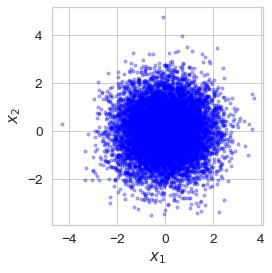

In [9]:
N = 10000
x_N2 = prng.multivariate_normal(zero_mean_2, identity_cov_22, size=N)
plt.plot(x_N2[:,0], x_N2[:,1], 'b.', alpha=0.3)
plt.gca().set_aspect('equal');
plt.xlabel('$x_1$');
plt.ylabel('$x_2$');

## Pair plot visualization of standard D=2 Gaussian

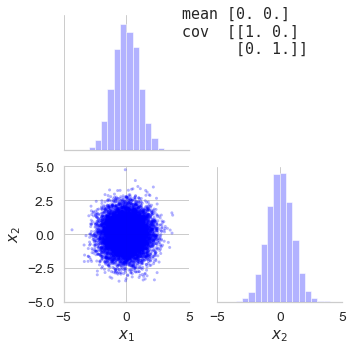

In [10]:
# Pack samples into a pandas dataframe to plot
x_df = pd.DataFrame(x_N2, columns=['$x_1$', '$x_2$'])

# Define consistent visual limits
ymax_hist = 100
xmax = 5.0
n_bins = 21

# Make the pair plot
h = sns.pairplot(
    x_df,
    aspect=1.0,
    corner=True, # only plot lower left half of square
    diag_kws={"color": 'b', "alpha": 0.3, "bins":np.linspace(-xmax, xmax, n_bins)},
    plot_kws={"color": 'b', "alpha": 0.3, 'marker': '.', 'edgecolor':'none'});
# ^- alpha here means transparency for the 'alpha' channel of the RGB-A scheme

# Set view limits of *diagonal plots* to a standardized window
for diag_tuple in [(0,0), (1,1)]:
    h.axes[diag_tuple[0], diag_tuple[1]].set_xlim([-xmax, xmax]);
    h.axes[diag_tuple[0], diag_tuple[1]].set_ylim([0, ymax_hist]);

# Set view limits of *off-diagonal* scatter plots to a standardized window
h.axes[1,0].set_xlim([-xmax, xmax]);
h.axes[1,0].set_ylim([-xmax, xmax]);

# Prettify the overall plot
plt.tight_layout();
plt.suptitle(
    "mean %s\ncov  %s" % (
        str(zero_mean_2),
        str(identity_cov_22).replace("\n","\n     ")), 
    fontsize=14,
    horizontalalignment='left',
    font='monospace');

## Discussion 1a: What can you say about x1 and x2 in terms of *independence*?

In [11]:
# TODO discuss

##  Sampling from a D=2 multivariate Gaussian with *negative correlations*


In [12]:
zero_mean_2 = np.zeros(2)
neg_corr_cov_22 = np.asarray([
    [3.0, -1.7],
    [-1.7, 1.0],
])

print("Mean")
print("-----")
print(zero_mean_2)
print("\nCovar")
print("-----")
print(neg_corr_cov_22)

Mean
-----
[0. 0.]

Covar
-----
[[ 3.  -1.7]
 [-1.7  1. ]]


In [13]:
prng.multivariate_normal(zero_mean_2, neg_corr_cov_22)

array([-1.121,  0.61 ])

In [14]:
prng.multivariate_normal(zero_mean_2, neg_corr_cov_22)

array([ 1.699, -1.433])

In [15]:
prng.multivariate_normal(zero_mean_2, neg_corr_cov_22)

array([ 1.639, -1.237])

In [16]:
prng.multivariate_normal(zero_mean_2, neg_corr_cov_22)

array([ 1.33 , -1.073])

## Discussion 1b: What do you notice about the relationship between x1 and x2 here? Is there something about their signs that is a consistent pattern?

In [17]:
# TODO discuss

## Draw many values from zero mean, negative correlation Normal

In [18]:
N = 10000
x_N2 = prng.multivariate_normal(zero_mean_2, neg_corr_cov_22, size=N)
print(x_N2[:3])
print("...")

[[-0.142 -0.092]
 [-0.168 -0.229]
 [-1.52   0.962]]
...


## Pair plot visualization with negative correlation

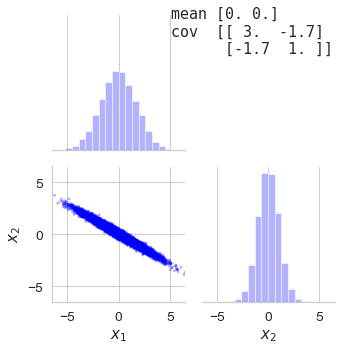

In [19]:
# Pack samples into a pandas dataframe to plot
x_df = pd.DataFrame(x_N2, columns=['$x_1$', '$x_2$'])

# Define consistent visual limits
ymax_hist = 100
xmax = 6.5
n_bins = 21

h = sns.pairplot(
    x_df,
    aspect=1.0,
    corner=True, # only plot lower left half of square
    diag_kws={"color": 'b', "alpha": 0.3, "bins":np.linspace(-xmax, xmax, n_bins)},
    plot_kws={"color": 'b', "alpha": 0.3, 'marker': '.', 'edgecolor':'none'},
    );
# ^- alpha here means transparency for the 'alpha' channel of the RGB-A scheme

# Set view limits of *diagonal plots* to a standardized window
for diag_tuple in [(0,0), (1,1)]:
    h.axes[diag_tuple[0], diag_tuple[1]].set_xlim([-xmax, xmax]);
    h.axes[diag_tuple[0], diag_tuple[1]].set_ylim([0, ymax_hist]);

# Set view limits of *off-diagonal* scatter plots to a standardized window
h.axes[1,0].set_xlim([-xmax, xmax]);
h.axes[1,0].set_ylim([-xmax, xmax]);

# Prettify the overall plot
plt.tight_layout();
plt.suptitle(
    "mean %s\ncov  %s" % (
        str(zero_mean_2),
        str(neg_corr_cov_22).replace("\n","\n     ")), 
    fontsize=14,
    horizontalalignment='left',
    font='monospace');

## Discussion 1b: Which of x1 or x2 has *smaller* marginal variance? Why?

How does what you see in the plots align with the definition of the covariance parameter here.

## Example with negative correlations AND non-zero mean

In [20]:
nonzero_mean_2 = np.asarray([2.0, -0.5])
neg_corr_cov_22 = np.asarray([
    [3.0, -1.7],
    [-1.7, 1.0],
])


Draw many samples

In [21]:
N = 10000
x_N2 = prng.multivariate_normal(nonzero_mean_2, neg_corr_cov_22, size=N)
print(x_N2[:3])
print("...")

[[ 3.724 -1.948]
 [-0.31   0.768]
 [ 2.17  -0.52 ]]
...


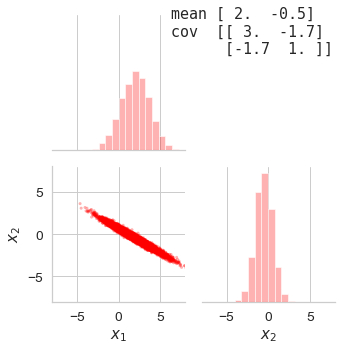

In [22]:
# Pack samples into a pandas dataframe to plot
x_df = pd.DataFrame(x_N2, columns=['$x_1$', '$x_2$'])

# Define consistent visual limits
ymax_hist = 100
xmax = 8
n_bins = 21

h = sns.pairplot(
    x_df,
    aspect=1.0,
    corner=True, # only plot lower left half of square
    diag_kws={"color": 'r', "alpha": 0.3, "bins":np.linspace(-xmax, xmax, n_bins)},
    plot_kws={"color": 'r', "alpha": 0.3, 'marker': '.', 'edgecolor':'none'},
    );
# ^- alpha here means transparency for the 'alpha' channel of the RGB-A scheme

# Set view limits of *diagonal plots* to a standardized window
for diag_tuple in [(0,0), (1,1)]:
    h.axes[diag_tuple[0], diag_tuple[1]].set_xlim([-xmax, xmax]);
    h.axes[diag_tuple[0], diag_tuple[1]].set_ylim([0, ymax_hist]);

# Set view limits of *off-diagonal* scatter plots to a standardized window
h.axes[1,0].set_xlim([-xmax, xmax]);
h.axes[1,0].set_ylim([-xmax, xmax]);

# Prettify the overall plot
plt.tight_layout();
plt.suptitle(
    "mean %s\ncov  %s" % (
        str(nonzero_mean_2),
        str(neg_corr_cov_22).replace("\n","\n     ")), 
    fontsize=14,
    horizontalalignment='left',
    font='monospace');

## Part 2: Estimate covariances from data

Let's take the *data* $x$ we observed in our previous plot above, and see if we can estimate the empirical covariance.

Remember, the data is in array `x_N2`


In [23]:
# Print out the array to remember what we're working with.
print("x_N2: shape = %s" % str(x_N2.shape))
print("----")
print(x_N2[:5])
print("...")
print(x_N2[-5:])

x_N2: shape = (10000, 2)
----
[[ 3.724 -1.948]
 [-0.31   0.768]
 [ 2.17  -0.52 ]
 [ 2.485 -0.895]
 [ 2.156 -0.222]]
...
[[ 0.873 -0.055]
 [ 4.296 -2.234]
 [ 0.007  0.397]
 [ 0.955  0.053]
 [ 0.706  0.336]]


## Exercise 2a: Compute the empirical covariance for $x_1, x_1$

Remember, the general formula for the empirical covariance of two **scalar** random variables is:

$$
\text{Cov}(X_i, X_j) = \frac{1}{N} \sum_{n=1}^N (x_{ni} - \mu_i) (x_{nj} - \mu_j)
$$

Now, we want to compute for $i=1, j=1$

$$
\text{Cov}(X_1, X_1) = ?
$$

In [24]:
mean_x1 = np.mean(x_N2[:,0])  
cov_x1_x1 = -999.0 # TODO compute

print("Cov[x_1, x_1]")
print("-------------")
print(cov_x1_x1)

Cov[x_1, x_1]
-------------
-999.0


## Exercise 2b: Compute the empirical covariance for $x_2, x_2$


In [25]:
## TODO compute just like in 2a

## Exercise 2c: Compute the empirical covariance for $x_1, x_2$:


In [26]:
## TODO compute just like 2a

## Exercise 2d: Compute the empirical covariance *matrix*

We can define the empirical covariance matrix as follows:

$$
\text{Cov}(X) = \frac{1}{N} \sum_{n=1}^N (x_{n} - \mu) (x_{n} - \mu)^T
$$

Inside the sum, that is an *outer product* of two vectors of size $D$

In general, the $i,j$-th entry of this $D \times D$ matrix will be exactly equal to computing the scalar covariance $\text{Cov}(X_i, X_j)$ via the formulas above in 2a

In [27]:
## TODO compute covariance as a 2x2 matrix

# Please edit this starter code

mean_2 = np.mean(x_N2, axis=0) # compute emprical mean of each column of x as a 2-dim vector
cov_22 = np.zeros((2,2))
for n in range(N):
    # Add the outer product related to the n-th data vector
    cov_22 += np.outer(x_N2[n,:], x_N2[n,:])  # TODO fix me to use correct formula
cov_22 = cov_22 / N # divide by N

print(cov_22)

[[ 6.945 -2.68 ]
 [-2.68   1.245]]


## Discussion 2e: Does your answers above match the "true" covariance that generated the data?

You should be able to look at the scalars in 2a, 2b, 2c, as well as the matrix in 2d, and see a good match.

Remember what the true cov was:

In [28]:
print(neg_corr_cov_22)

[[ 3.  -1.7]
 [-1.7  1. ]]


In [29]:
# TODO discuss if your estimated empirical covariance is "close" to the true

## Demo 2f: A *short cut* to compute the empirical covariance

Use the built in function "numpy.cov". 

See https://numpy.org/doc/stable/reference/generated/numpy.cov.html

In [30]:
empirical_cov_22 = np.cov(x_N2.T, bias=True) # Make sure to pass data array as 2 x N

In [31]:
print("empirical_cov_22")
print("----------------")
print(empirical_cov_22)

empirical_cov_22
----------------
[[ 3.014 -1.71 ]
 [-1.71   1.006]]


## Demo 2g: Computing empirical covariance using matrix-vector ops

$$
\text{Cov}(X) = \frac{1}{N} A^T A, \quad A = X - \mu
$$

where $A$ is an $N \times 2$ matrix with each row containing the *centered* data $x_n - \mu$

In [32]:
mu_2 = np.mean(x_N2, axis=0)
x_diff_mu_N2 = x_N2 - mu_2[np.newaxis,:] # subtract mu from each row of x
empirical_cov_22 = 1 / N * np.dot(x_diff_mu_N2.T, x_diff_mu_N2) # dot does a
print("empirical_cov_22")
print("----------------")
print(empirical_cov_22)

empirical_cov_22
----------------
[[ 3.014 -1.71 ]
 [-1.71   1.006]]


# Part 3: Visualization of the PDF as a *contour* plot

In lecture, we learned that the contours of 2D Gaussians are elliptical.

Below, we see a function that shows in NumPy how to plot the contours of a given Gaussian distribution.

Please skim thru the function to understand how it works.

In [33]:
def plotGauss2DEllipticalContours(
        mean_D, cov_DD,
        color='b',
        radius_lengths=[0.333, 1.333, 3.0], # just chosen to look "reasonable"
        markersize=3.0,
        unit_circle_radian_step_size=0.03,
        ax_handle=None,
        ):
    ''' Plot elliptical contours for provided mean and covariance
    
    Args
    ----
    mu_D : 1D numpy array, shape (D,) = (2,)
        Must be a 2-d mean vector
    cov_DD : 2D numpy array, shape (D,D) = (2,2)
        Must be a 2x2 symmetric, positive definite covariance
    radius_lengths : list
        Each entry gives the "radius" of a desired contour.
        FUTURE: could be computed to contain certain fractions of all probability mass.

    Post Condition
    --------------
    Plot created on current axes (or the provided axis)
    '''
    # If user provided an axis, use that
    if ax_handle is not None:
        plt.sca(ax_handle)

    mu_D = np.squeeze(np.asarray(mean_D))
    D = mu_D.size
    cov_DD = np.asarray(cov_DD)
    assert mu_D.shape == (2,)
    assert cov_DD.shape == (2,2)
    
    # Decompose cov matrix into eigenvalues "lambda[d]" and eigenvectors "U[:,d]"
    lambda_D, U_DD = np.linalg.eig(cov_DD)

    # Verify orthonormal
    assert np.allclose(np.eye(D), np.dot(U_DD, U_DD.T))
    # View eigenvector matrix as a rotation transformation
    rot_DD = U_DD
    
    # Prep for plotting elliptical contours
    # by creating grid of G different (x,y) points along perfect circle
    # Recall that a perfect circle is swept by considering all radians between [-pi, +pi]
    t_G = np.arange(-np.pi, np.pi, unit_circle_radian_step_size)
    x_G = np.sin(t_G)
    y_G = np.cos(t_G)
    Zcirc_DG = np.vstack([x_G, y_G])

    # Warp circle into ellipse defined by Sigma's eigenvectors
    # Rescale according to eigenvalues
    Zellipse_DG = np.sqrt(lambda_D)[:,np.newaxis] * Zcirc_DG
    # Rotate according to eigenvectors
    Zrotellipse_DG = np.dot(rot_DD, Zellipse_DG)
    
    # Plot contour lines across several radius lengths
    for r in radius_lengths:
        Z_DG = r * Zrotellipse_DG + mu_D[:, np.newaxis]
        plt.plot(
            Z_DG[0], Z_DG[1], '.-',
            color=color,
            markersize=markersize,
            markerfacecolor=color,
            markeredgecolor=color)


## Discussion 3a: Why do we use the square root of the eigenvalues (lambda_D) to warp the circle into an ellipse?

In [34]:
# TODO discuss

## Discussion 3b: What properties of the eigenvector matrix make it a valid rotation matrix?

In [35]:
# TODO discuss

# Contours for a Standard Normal with D=2

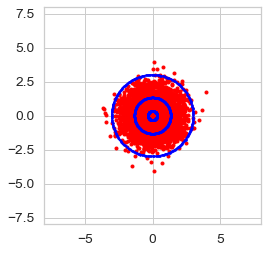

In [36]:
mu_D = np.asarray([0, 0])
cov_DD = np.asarray([[1, 0 ], [0, 1]])

# First, plot N samples
N = 5000
x_N2 = scipy.stats.multivariate_normal.rvs(mu_D, cov_DD, N)
plt.plot(x_N2[:,0], x_N2[:,1], 'r.')

# Second, plot the contours
plotGauss2DEllipticalContours(mu_D, cov_DD)

B = 8
plt.gca().set_aspect('equal', 'box');
plt.gca().set_xlim([-B, B]);
plt.gca().set_ylim([-B, B]);

## Demo: Contours for 2D Normal w/ 3-times-larger variance on x axis


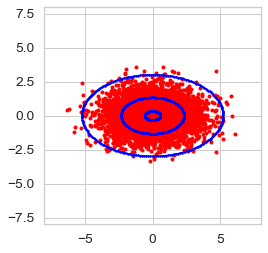

In [37]:
mu_D = np.asarray([0, 0])
cov_DD = np.asarray([[3, 0 ], [0, 1]])

# First, plot N samples
N = 5000
x_N2 = scipy.stats.multivariate_normal.rvs(mu_D, cov_DD, N)
plt.plot(x_N2[:,0], x_N2[:,1], 'r.')

# Second, plot the contours
plotGauss2DEllipticalContours(mu_D, cov_DD)

B = 8
plt.gca().set_aspect('equal', 'box');
plt.gca().set_xlim([-B, B]);
plt.gca().set_ylim([-B, B]);

## Exercise 3c: Contours for 2D Normal w/ strong negative correlation

In [44]:
mu_D = np.asarray([0, 0])
cov_DD = np.asarray([[1, -1.5], [-1.5, 4]])

# TODO make plots as above.

## Exercise 3d: Can you show the covariance matrix is positive definite?

You should try:

* Compute the eigenvalues and show they are all positive.
* * See https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html
* Compute the determinant using `np.linalg.det` and show it is positive.
* * See https://numpy.org/doc/stable/reference/generated/numpy.linalg.det.html
* Show that a cholesky factorization exists
* * See https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html

First, print out the covariance matrix

In [45]:
cov_DD

array([[ 1. , -1.5],
       [-1.5,  4. ]])

In [56]:
# TODO compute eigenvalues and show they are all positive. See np.linalg.eig


In [57]:
# TODO call np.linalg.det on cov_DD


In [53]:
L_DD = np.linalg.cholesky(cov_DD)
print(L_DD)

[[ 1.     0.   ]
 [-1.5    1.323]]


In [58]:
# TODO show that matrix_multiply of L_DD and L_DD.T reconstructs cov_DD
# use np.dot(A, B) to do matrix multiplication
